In [1]:
run ../prep_ana.py

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loading plotting specs...
8 or 13 TeV:8TeV
unc_mc_process and scales as dictionaries
Load MC and Data?False
df = pd.concat([df_dy0, df_dy1, df_dy2, df_dy3, df_dy4, df_dy_m_10, df_ww, df_tt_l, df_tt_sl, df_zz_ln, df_wz_ln, df_wz_lq ])


In [2]:
%matplotlib inline

In [3]:
columns=None


df_tt_l = rp.read_root(data_path+"/ttbar_leptonic_complete.root", columns=columns)
df_tt_sl = rp.read_root(data_path+"/ttbar_semileptonic_complete.root", columns=columns)
df_tbar_tw = rp.read_root(data_path+"/tbar_tw-_complete.root", columns=columns)
df_tbar_s = rp.read_root(data_path+"/tbar_s-_complete.root", columns=columns)
df_tbar_t = rp.read_root(data_path+"/tbar_t-_complete.root", columns=columns)
df_t_tw = rp.read_root(data_path+"/t_tw-_complete.root", columns=columns)
df_t_s = rp.read_root(data_path+"/t_s-_complete.root", columns=columns)
df_t_t = rp.read_root(data_path+"/t_t-_complete.root", columns=columns)



df = pd.concat([df_tt_l, df_tt_sl, df_tbar_s, df_tbar_t, df_tbar_tw, df_t_s, df_t_t, df_t_tw])

In [4]:
df.keys()

Index([u'lep1_pt', u'lep2_pt', u'lep3_pt', u'numb_jets', u'dPhiLL', u'qT',
       u'HT', u'lep1_Charge', u'lep2_Charge', u'lep_Type', u'lep1_type',
       u'lep2_type', u'lep1_eta', u'lep2_eta', u'lep1_phi', u'lep2_phi',
       u'lep1_iso', u'lep2_iso', u'soft_muon_pt', u'soft_muon_phi',
       u'soft_muon_eta', u'lep1_mother', u'lep2_mother', u'met_corrected',
       u'met_trk', u'metMod', u'jet1_pt', u'jet2_pt', u'jet3_pt', u'jet4_pt',
       u'jet5_pt', u'jet6_pt', u'jet1_csv', u'jet2_csv', u'jet3_csv',
       u'jet1_phi', u'jet2_phi', u'jet1_eta', u'jet2_eta', u'numbExtraLep',
       u'mll', u'mllMET', u'recoil', u'dPhiLLJet', u'numb_BJet',
       u'numb_BJet_gen', u'dPhiLLMET', u'dPhiMETJet', u'METProj',
       u'METProj_sin', u'METProj_trk_sin', u'met_phi', u'met_corrected_phi',
       u'met_trk_phi', u'met_over_sET', u'nPartons', u'npv', u'tot_npv',
       u'gen_npv', u'runNum', u'lumiSec', u'eventNumb', u'weight',
       u'nov_weight', u'id_weight', u'mu_id_weight', u'el1_id_we

In [8]:
df[(df.numb_BJet_gen >= 1) & (df.numb_jets >= 1) & (df.numb_jets < 4)].shape

(1970119, 74)

In [16]:
ptmin = [30, 40, 50, 60, 70, 80, 100, 120, 160, 210, 260, 320, 400, 500]
ptmax = [40, 50, 60, 70, 80,100, 120, 160, 210, 260, 320, 400, 500, 670]

true_bjet = []
csv_bjet = []
for i in range(len(ptmin)):
    ptmin_str = str(ptmin[i])
    ptmax_str = str(ptmax[i])
    true_bjet.append(df.query("(numb_jets == 1) & (jet1_pt > " + ptmin_str + ") & (jet1_pt < " + ptmax_str +") & (numb_BJet_gen == 1) ").shape[0])
    csv_bjet.append(df.query("(numb_jets == 1) & (jet1_pt > " + ptmin_str + ") & (jet1_pt < " + ptmax_str +") & (numb_BJet_gen == 1) & (numb_BJet == 1)").shape[0]) 

true_bjet = np.array(true_bjet, dtype=np.float64)
csv_bjet = np.array(csv_bjet, dtype=np.float64)

eff_MCbjet = csv_bjet / true_bjet

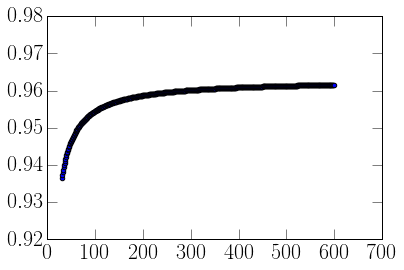

In [17]:
x = [i for i in xrange(30,600)]
y = [0.6981*((1.+(0.414063*i))/(1.+(0.300155*i))) for i in x]

plt.scatter(x, y)

In [17]:
# Determine Data eff
eff_Dabjet = []
for i in range(len(ptmin)):
    pt = (ptmin[i] + ptmax[i]) / 2.
    eff_Dabjet.append(0.6981*((1.+(0.414063*pt))/(1.+(0.300155*pt))) * eff_MCbjet[i])
eff_Dabjet = np.array(eff_Dabjet)


In [19]:
#Calc 1 - effs 
(1 - eff_Dabjet) / (1 - eff_MCbjet)

array([ 1.03893201,  1.04637392,  1.0512145 ,  1.0540898 ,  1.05693119,
        1.0534045 ,  1.05495687,  1.05088192,  1.03420739,  1.02763589,
        1.02039529,  1.01457655,  1.00648666,  1.0149618 ])

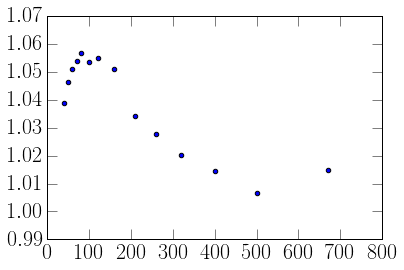

In [21]:
plt.scatter(ptmax, (1 - eff_Dabjet) / (1 - eff_MCbjet))